# DATA 5610 - Project 0
Dallin Moore

## The Problem:
Youtube wants to know what makes videos trending in order to drive engagement across the site.

## The Dataset:
The dataset contains trending videos from the US (269k entries) with columns: `video_id`(unique identifier), `title`, `publishedAt`(time the video was published), `channelId`(unique channel identifier), `channelTitle`(name of the channel), `categoryId`(unique identifier for the category), `trending_date`(when was the video on the trending page), `tags`(set of tags seperated by '|'), `view_count`(how many views it had when the video was scraped from the trending page), `likes`, `dislikes`, `comment_count`, `thumbnail_link`, `comments_disabled`(if the comments were disabled, value is True), `ratings_disabled`(), `description`(text description of the video provided by the creator).

The dataset was accessed [here](https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset?select=US_youtube_trending_data.csv) and reflects trending videos from 2020/08/03 to 2024/04/14.


## Import and Explore the Data:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import json

import nltk
import re
import numpy as np

nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\04drm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\04drm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
df_original = pd.read_csv('./data/US_youtube_trending_data.csv')
df_original.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268787 entries, 0 to 268786
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           268787 non-null  object
 1   title              268787 non-null  object
 2   publishedAt        268787 non-null  object
 3   channelId          268787 non-null  object
 4   channelTitle       268787 non-null  object
 5   categoryId         268787 non-null  int64 
 6   trending_date      268787 non-null  object
 7   tags               268787 non-null  object
 8   view_count         268787 non-null  int64 
 9   likes              268787 non-null  int64 
 10  dislikes           268787 non-null  int64 
 11  comment_count      268787 non-null  int64 
 12  thumbnail_link     268787 non-null  object
 13  comments_disabled  268787 non-null  bool  
 14  ratings_disabled   268787 non-null  bool  
 15  description        264238 non-null  object
dtypes: bool(2), int64(5)

In [4]:
df_original.describe()

,categoryId,view_count,likes,dislikes,comment_count
count,268787.000000,2.687870e+05,2.687870e+05,268787.000000,2.687870e+05
mean,18.743511,2.734467e+06,1.314697e+05,1134.277495,1.014303e+04
std,6.786562,9.794087e+06,4.539469e+05,8047.291315,7.260853e+04
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,17.000000,4.725410e+05,1.796300e+04,0.000000,1.280000e+03
50%,20.000000,9.368710e+05,4.020500e+04,0.000000,2.754000e+03
75%,24.000000,2.106178e+06,9.877300e+04,467.000000,6.386000e+03
max,29.000000,1.407644e+09,1.602153e+07,879354.000000,6.738537e+06


In [5]:
df_original.value_counts()

video_id     title                                                                       publishedAt           channelId                 channelTitle                    categoryId  trending_date         tags                                                                                                                                                                                                                                                                                                                                                                                                                                           view_count  likes   dislikes  comment_count  thumbnail_link                                  comments_disabled  ratings_disabled  description                                                                                                                                                                                                                                 

In [6]:
# display rows of the dataframe where the 'video_id' column is 'KTg6DVwoJlk'  
df_original.loc[df_original['video_id'] == 'KTg6DVwoJlk']

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
186197,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24T01:30:35Z,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-02-25T00:00:00Z,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,742483,63915,0,10206,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...
186416,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24T01:30:35Z,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-02-26T00:00:00Z,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,1022711,80083,0,11523,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...
186648,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24T01:30:35Z,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-02-27T00:00:00Z,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,1176123,87969,0,12079,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...
186888,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24T01:30:35Z,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-02-28T00:00:00Z,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,1283628,93168,0,12666,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...
187130,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24T01:30:35Z,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-03-01T00:00:00Z,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,1352836,96153,0,12899,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...
187361,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24T01:30:35Z,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-03-02T00:00:00Z,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,1410622,98683,0,12980,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...


## Data Transformation:

There appear to be some videos that were captured as trending multiple times. We will grab the max values and add a column 'times_trending' to count the number of times that value appears in the dataset.

In [7]:
# Create a copy of the DataFrame
df = df_original.copy()

# Convert 'trending_date' and 'publishedAt' to datetime
df['trending_date'] = pd.to_datetime(df['trending_date'])
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [8]:
# Group by 'video_id' and count the number of occurrences
df['times_trending'] = df.groupby('video_id')['video_id'].transform('count')

# Sort by 'video_id' and 'trending_date' to keep the latest trending date
df = df.sort_values(by=['video_id', 'trending_date'], ascending=[True, False])

# Drop duplicates, keeping the row with the greatest 'trending_date'
df = df.drop_duplicates(subset='video_id', keep='first')

df.loc[df['video_id'] == 'KTg6DVwoJlk']

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,times_trending
187361,KTg6DVwoJlk,AMP LOVE & MUSIC,2023-02-24 01:30:35+00:00,UCJbYdyufHR-cxOuY96KIoqA,AMP,24,2023-03-02 00:00:00+00:00,AMP LOVE & MUSIC|KAI CENAT|DUKE DENNIS|AGENT 0...,1410622,98683,0,12980,https://i.ytimg.com/vi/KTg6DVwoJlk/default.jpg,False,False,ALMOST AT 100K ON THE POD CHAN SUB NOW HELP US...,6


### Convert Category to String

In [9]:
# Load the JSON data
with open('./data/US_category_id.json', 'r') as file:
    category_data = json.load(file)

# Create a dictionary with the category_id as the key and the category as the value
category_dict = {}
for category in category_data['items']:
    category_dict[int(category['id'])] = category['snippet']['title']
print(category_dict)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [10]:
# Map the 'categoryId' to the category in 'category_dict'
df['category'] = df['categoryId'].map(category_dict)
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,times_trending,category
62481,--14w5SOEUs,Migos - Avalanche (Official Video),2021-06-10 16:00:00+00:00,UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,10,2021-06-15 00:00:00+00:00,Migos|Avalanche|Quality|Control|Music/Motown|R...,6553613,258885,3977,16296,https://i.ytimg.com/vi/--14w5SOEUs/default.jpg,False,False,Watch the the official video for Migos - Avala...,10,Music
116969,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,2022-03-09 23:19:08+00:00,UCXJEvxZSozjAAqhbMfhIArA,jf.okay,24,2022-03-15 00:00:00+00:00,[None],538485,17290,0,1439,https://i.ytimg.com/vi/--2O86Z0hsM/default.jpg,False,False,NaN,4,Entertainment
83138,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,2021-09-20 01:03:32+00:00,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,24,2021-09-25 00:00:00+00:00,[None],682609,8029,369,723,https://i.ytimg.com/vi/--40TEbZ9Is/default.jpg,False,False,Hannah Waddingham wins the Emmy for Supporting...,5,Entertainment
246373,--47FjCWgrU,San Francisco 49ers vs. Arizona Cardinals Game...,2023-12-18 00:21:58+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2023-12-25 00:00:00+00:00,[None],1940781,22612,0,2018,https://i.ytimg.com/vi/--47FjCWgrU/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,7,Sports
174003,--5-brQiQFg,Washington Commanders vs. San Francisco 49ers ...,2022-12-25 00:30:17+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2022-12-26 00:00:00+00:00,[None],1280997,14603,0,2078,https://i.ytimg.com/vi/--5-brQiQFg/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,1,Sports


### Split up the 'tags' column

Make the values into a list, if the column has '[None]', leave it empty.

In [11]:
# Replace '[None]' with an empty string
df['tags'] = df['tags'].replace('[None]', '')

# Split the 'tags' column into a list of tags
df['tags'] = df['tags'].str.split('|')

# Display the updated dataframe
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,times_trending,category
62481,--14w5SOEUs,Migos - Avalanche (Official Video),2021-06-10 16:00:00+00:00,UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,10,2021-06-15 00:00:00+00:00,"[Migos, Avalanche, Quality, Control, Music/Mot...",6553613,258885,3977,16296,https://i.ytimg.com/vi/--14w5SOEUs/default.jpg,False,False,Watch the the official video for Migos - Avala...,10,Music
116969,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,2022-03-09 23:19:08+00:00,UCXJEvxZSozjAAqhbMfhIArA,jf.okay,24,2022-03-15 00:00:00+00:00,[],538485,17290,0,1439,https://i.ytimg.com/vi/--2O86Z0hsM/default.jpg,False,False,NaN,4,Entertainment
83138,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,2021-09-20 01:03:32+00:00,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,24,2021-09-25 00:00:00+00:00,[],682609,8029,369,723,https://i.ytimg.com/vi/--40TEbZ9Is/default.jpg,False,False,Hannah Waddingham wins the Emmy for Supporting...,5,Entertainment
246373,--47FjCWgrU,San Francisco 49ers vs. Arizona Cardinals Game...,2023-12-18 00:21:58+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2023-12-25 00:00:00+00:00,[],1940781,22612,0,2018,https://i.ytimg.com/vi/--47FjCWgrU/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,7,Sports
174003,--5-brQiQFg,Washington Commanders vs. San Francisco 49ers ...,2022-12-25 00:30:17+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2022-12-26 00:00:00+00:00,[],1280997,14603,0,2078,https://i.ytimg.com/vi/--5-brQiQFg/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,1,Sports


### Create an 'elapsed_time_trending' column

Create a column that finds the difference between when the video was trending and when it was first published.

In [12]:
# Calculate the difference between 'trending_date' and 'publishedAt'
df['elapsed_time_trending'] = (df['trending_date'] - df['publishedAt']).dt.total_seconds() / 3600

df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,times_trending,category,elapsed_time_trending
62481,--14w5SOEUs,Migos - Avalanche (Official Video),2021-06-10 16:00:00+00:00,UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,10,2021-06-15 00:00:00+00:00,"[Migos, Avalanche, Quality, Control, Music/Mot...",6553613,258885,3977,16296,https://i.ytimg.com/vi/--14w5SOEUs/default.jpg,False,False,Watch the the official video for Migos - Avala...,10,Music,104.000000
116969,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,2022-03-09 23:19:08+00:00,UCXJEvxZSozjAAqhbMfhIArA,jf.okay,24,2022-03-15 00:00:00+00:00,[],538485,17290,0,1439,https://i.ytimg.com/vi/--2O86Z0hsM/default.jpg,False,False,NaN,4,Entertainment,120.681111
83138,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,2021-09-20 01:03:32+00:00,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,24,2021-09-25 00:00:00+00:00,[],682609,8029,369,723,https://i.ytimg.com/vi/--40TEbZ9Is/default.jpg,False,False,Hannah Waddingham wins the Emmy for Supporting...,5,Entertainment,118.941111
246373,--47FjCWgrU,San Francisco 49ers vs. Arizona Cardinals Game...,2023-12-18 00:21:58+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2023-12-25 00:00:00+00:00,[],1940781,22612,0,2018,https://i.ytimg.com/vi/--47FjCWgrU/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,7,Sports,167.633889
174003,--5-brQiQFg,Washington Commanders vs. San Francisco 49ers ...,2022-12-25 00:30:17+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2022-12-26 00:00:00+00:00,[],1280997,14603,0,2078,https://i.ytimg.com/vi/--5-brQiQFg/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,1,Sports,23.495278


### Preprocess Text Data

The 'tags', the 'description', and the 'title' column all have text data that will be useful to the analysis.

The 'times_trending', the 'likes' (not 'dislikes' as the data is missing for many videos), the 'view_count', the 'elapsed_time_trending' are all numeric data that does not need to be vectorized.

In [13]:
text_column = [
    'tags',
    'description',
    'title',
    'category'
]
numeric_columns = [
    'times_trending',
    'likes',
    'view_count',
    'elapsed_time_trending'
]

for column in text_column:
    df[column].astype(str).fillna('',inplace=True)
for column in numeric_columns:
    df[column].fillna(0,inplace=True)

In [14]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # Substitute line breaks with spaces
    doc = doc.replace('\n', ' ')
    # Lower case and remove special characters except letters a-z and spaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc)
    doc = doc.lower()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

In [15]:
# Fill NaNs with empty strings
df['description'] = df['description'].fillna('')
df['title'] = df['title'].fillna('')

# Apply the normalize_document function
df['description'] = df['description'].apply(normalize_document)
df['title'] = df['title'].apply(normalize_document)

df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,times_trending,category,elapsed_time_trending
62481,--14w5SOEUs,migos avalanche official video,2021-06-10 16:00:00+00:00,UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,10,2021-06-15 00:00:00+00:00,"[Migos, Avalanche, Quality, Control, Music/Mot...",6553613,258885,3977,16296,https://i.ytimg.com/vi/--14w5SOEUs/default.jpg,False,False,watch official video migos avalanchestream dow...,10,Music,104.000000
116969,--2O86Z0hsM,tesla pays,2022-03-09 23:19:08+00:00,UCXJEvxZSozjAAqhbMfhIArA,jf.okay,24,2022-03-15 00:00:00+00:00,[],538485,17290,0,1439,https://i.ytimg.com/vi/--2O86Z0hsM/default.jpg,False,False,,4,Entertainment,120.681111
83138,--40TEbZ9Is,supporting actress comedy rd emmys,2021-09-20 01:03:32+00:00,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,24,2021-09-25 00:00:00+00:00,[],682609,8029,369,723,https://i.ytimg.com/vi/--40TEbZ9Is/default.jpg,False,False,hannah waddingham wins emmy supporting actress...,5,Entertainment,118.941111
246373,--47FjCWgrU,san francisco ers vs arizona cardinals game hi...,2023-12-18 00:21:58+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2023-12-25 00:00:00+00:00,[],1940781,22612,0,2018,https://i.ytimg.com/vi/--47FjCWgrU/default.jpg,False,False,check channels nfl mundo https www youtube com...,7,Sports,167.633889
174003,--5-brQiQFg,washington commanders vs san francisco ers wee...,2022-12-25 00:30:17+00:00,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2022-12-26 00:00:00+00:00,[],1280997,14603,0,2078,https://i.ytimg.com/vi/--5-brQiQFg/default.jpg,False,False,check channels nfl mundo https www youtube com...,1,Sports,23.495278


### Vectorize the Data



In [16]:
def custom_tokenizer(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize and return
    return text.split()

tfidf_vectorizer = TfidfVectorizer(max_features=500, tokenizer=custom_tokenizer)
tfidf_dfs = []

for column in text_column:
    if column == 'tags':
        df[column] = df[column].apply(lambda x: ' '.join(x))
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"{column}_{feature}" for feature in tfidf_vectorizer.get_feature_names_out()])
    tfidf_dfs.append(tfidf_df)

# Concatenate all the tfidf dataframes horizontally
tfidf_df = pd.concat(tfidf_dfs, axis=1)

# Concatenate the tfidf dataframe with the numeric columns
result_df = pd.concat([tfidf_df, df[numeric_columns].reset_index(drop=True)], axis=1)
result_df.head()

c:\Users\04drm\anaconda3\envs\deep_forecasting\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,tags_&,tags_-,tags_.,tags_a,tags_action,tags_adventure,tags_aew,tags_album,tags_alex,tags_all,...,category_science,category_sports,category_style,category_technology,category_travel,category_vehicles,times_trending,likes,view_count,elapsed_time_trending
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,258885,6553613,104.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,17290,538485,120.681111
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,8029,682609,118.941111
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,7,22612,1940781,167.633889
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,14603,1280997,23.495278


## Train the Model

### Test/Train Split

In [17]:
X = result_df.drop("view_count", axis=1)
y = result_df["view_count"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state = 42)
X_train.shape, X_val.shape, X_test.shape

((30052, 1528), (10018, 1528), (7072, 1528))

### Models

In [ ]:
# AdaBoost Regressor
ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_val)

ada_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
ada_r2 = r2_score(y_val, y_pred)

print(f"AdaBoost Regressor RMSE: {ada_rmse:.4f}, R2 Score: {ada_r2:.4f}")


AdaBoost Regressor RMSE: 14952743.9823, R2 Score: -5.1231


In [33]:
# RandomForest Regressor with parallelism
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)  # Using all cores
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rf_r2 = r2_score(y_val, y_pred)

print(f"RandomForest Regressor RMSE: {rf_rmse:.4f}, R2 Score: {rf_r2:.4f}")


RandomForest Regressor RMSE: 2683622.6105, R2 Score: 0.8028


In [ ]:
# DecisionTree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_val)

dt_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
dt_r2 = r2_score(y_val, y_pred)

print(f"DecisionTree Regressor RMSE: {dt_rmse:.4f}, R2 Score: {dt_r2:.4f}")


DecisionTree Regressor RMSE: 3879223.2106, R2 Score: 0.5879


In [ ]:
# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_jobs=-1)  # Parallelize KNN
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_val)

knn_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
knn_r2 = r2_score(y_val, y_pred)

print(f"K-Nearest Neighbors Regressor RMSE: {knn_rmse:.4f}, R2 Score: {knn_r2:.4f}")


K-Nearest Neighbors Regressor RMSE: 3910120.4913, R2 Score: 0.5813


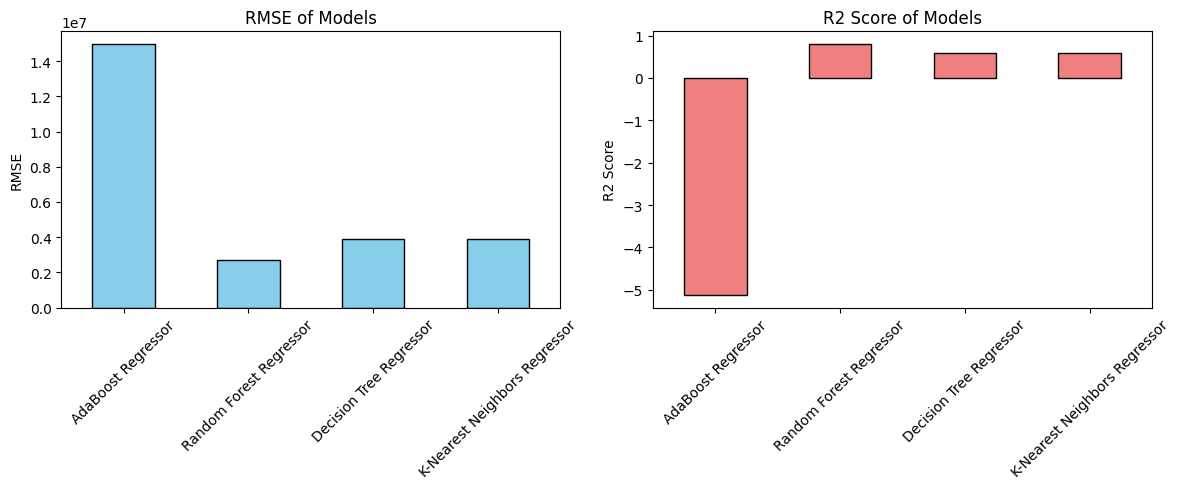

In [30]:
# Combine results from each model
results = {
    "AdaBoost Regressor": {"RMSE": ada_rmse, "R2": ada_r2},
    "Random Forest Regressor": {"RMSE": rf_rmse, "R2": rf_r2},
    "Decision Tree Regressor": {"RMSE": dt_rmse, "R2": dt_r2},
    "K-Nearest Neighbors Regressor": {"RMSE": knn_rmse, "R2": knn_r2},
}

results_df = pd.DataFrame(results).T

# Plot RMSE and R2 scores
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE Plot
results_df["RMSE"].plot(kind="bar", ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title("RMSE of Models")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(results_df.index, rotation=45)

# R2 Score Plot
results_df["R2"].plot(kind="bar", ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_title("R2 Score of Models")
axes[1].set_ylabel("R2 Score")
axes[1].set_xticklabels(results_df.index, rotation=45)

plt.tight_layout()
plt.show()


RandomForest Regressor was the best model so it will be used for the following analysis.

## Feature Importance

Top 10 Important Features:
likes: 0.7517
elapsed_time_trending: 0.0462
times_trending: 0.0107
description_bts: 0.0105
tags_kpop: 0.0040
description_films: 0.0039
title_mv: 0.0037
description_https: 0.0036
description_ad: 0.0035
description_facebook: 0.0032


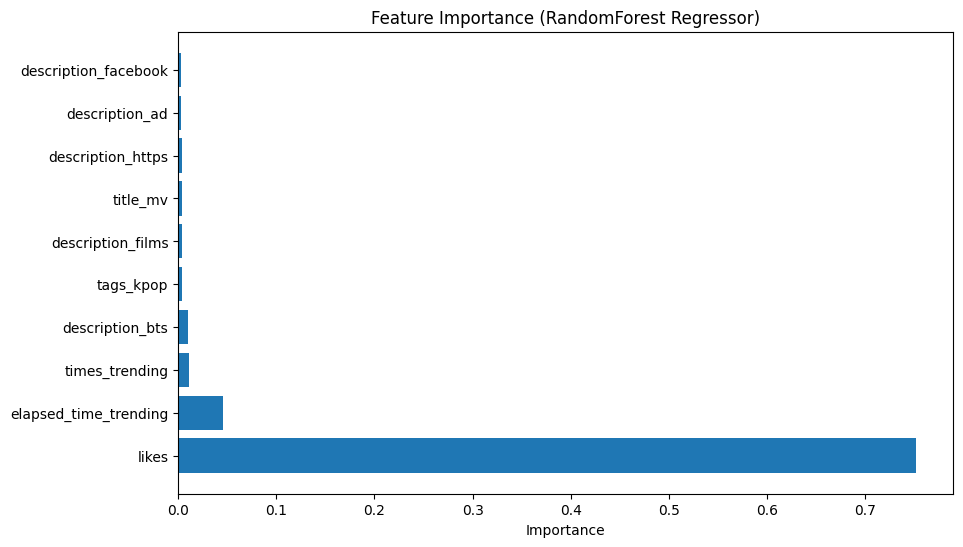

In [34]:
# Feature importance from RandomForest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the top 10 most important features
print("Top 10 Important Features:")
for i in range(10):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")
    
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (RandomForest Regressor)")
plt.barh(range(10), importances[indices[:10]], align="center")
plt.yticks(range(10), X_train.columns[indices[:10]])
plt.xlabel("Importance")
plt.show()
